# Fitting Proteins

In [1]:
import os
import itertools
import glob
import parmed
from simtk.openmm import app
from simtk import unit
from oeommtools import utils as oeo_utils
from chemper.smirksify import SMIRKSifier

In [2]:
residues = ['ALA', 'ASN', 'CYS', 'GLU', 'HIS',
            'LEU', 'MET', 'PRO', 'THR', 'TYR',
            'ARG', 'ASP', 'GLN', 'GLY', 'ILE',
            'LYS', 'PHE', 'SER', 'TRP', 'VAL']

In [68]:
from openeye import oechem, oeomega, oedepict
import IPython
from IPython.display import display, Image

def depictMatch(mol, match=None, supH = True, idx_atoms=list(), width=500, height=200, fn=None,
               color1=oechem.OELightBlue, color2=oechem.OELightSalmon, include_bonds=True):
    
    atom_bond_set = oechem.OEAtomBondSet()
    for atom in mol.GetAtoms():
        if atom.GetIdx() in idx_atoms:
            atom_bond_set.AddAtom(atom)
            if not include_bonds:
                continue
            for bond in atom.GetBonds():
                nbr_atom = bond.GetNbr(atom)
                if (nbr_atom.GetIdx() in idx_atoms) and nbr_atom.GetIdx() > atom.GetIdx():
                    atom_bond_set.AddBond(bond)
    
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetDepictOrientation( oedepict.OEDepictOrientation_Horizontal)
    dopt.SetSuppressHydrogens(supH)
    oedepict.OEPrepareDepiction(mol, dopt)
    
    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetAtomColorStyle(oedepict.OEAtomColorStyle_WhiteMonochrome)
    disp = oedepict.OE2DMolDisplay(mol, opts)
    
    # Highlight indexed atoms
    hstyle = oedepict.OEHighlightStyle_Cogwheel
    hcolor = oechem.OEColor(color1)
    if not atom_bond_set.IsEmpty():
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, atom_bond_set)
    
    if match is not None:
        # Highlight whole match
        hstyle = oedepict.OEHighlightStyle_BallAndStick
        hcolor = oechem.OEColor(color2)
        oedepict.OEAddHighlighting(disp, hcolor, hstyle, match)
    
    img = oedepict.OEImage(width, height)
    oedepict.OERenderMolecule(img,disp)
    
    if fn is not None:
        ext = oechem.OEGetFileExtension(fn)
        if oedepict.OEIsRegisteredImageFile(ext):
            ofs = oechem.oeofstream()
            if not ofs.open(fn):
                print("OE could not open file due to error %s" % fn)
                ofs.close()
            else:
                oedepict.OERenderMolecule(ofs, ext, disp)
                ofs.close()
        else:
            print("OE could not handle extension on %s" % fn)
    return img

## Dipeptides

I realized in this process that we don't need a separate `leap.in` file for each "protein"
so instead I will make one master input file that will parameterize all of the molecules 

In [4]:
def make_leap_str_dipeps(pairs, directory):
    """
    Parameters
    ----------
    residues: list like 
        contains 2 of the three letter residue codes
    directory: str
        path to where the output files should be stored
    
    Returns
    -------
    leap_lines: a string for the lines for the list of 
    """
    leap_str = """
divaline = sequence {N%s C%s}
savepdb divaline %s.pdb
protein = loadpdb %s.pdb
saveamberparm protein %s.prmtop %s.inpcrd
"""
    p0, p1 = pairs
    # fill in leap.in format
    fn = "%s/%s_%s" % (directory, p0, p1)
    out = leap_str % (p0, p1, fn, fn, fn, fn)

    leap_str4 = """
divaline = sequence {NALA %s %s CALA}
savepdb divaline %s.pdb
protein = loadpdb %s.pdb
saveamberparm protein %s.prmtop %s.inpcrd
"""
    fn4 = "%s/%s_%s_tetra" % (directory, p0, p1)
    out4 = leap_str4 % (p0, p1, fn4, fn4, fn4, fn4)
    
    return out, out4

def make_leap_str_tripeps(triplets, directory):
    """
    Parameters
    ----------
    residues: list like 
        contains 3 of the three letter residue codes
    directory: str
        path to where the output files should be stored
    
    Returns
    -------
    leap_lines: a string for the lines for the list of 
    """
    leap_str = """
divaline = sequence {N%s %s C%s}
savepdb divaline %s.pdb
protein = loadpdb %s.pdb
saveamberparm protein %s.prmtop %s.inpcrd
"""
    p0, p1, p2 = triplets
    # fill in leap.in format
    fn = "%s/%s_%s_%s" % (directory, p0, p1, p2)
    out = leap_str % (p0, p1, p2, fn, fn, fn, fn)
    return out


In [5]:
# create a list of all dipeptides
di_peps = itertools.combinations(residues, 2)
tri_peps = itertools.combinations(residues, 3)

# create input file
input_leap = "leap.in"
leap_in = open(input_leap, 'w')
leap_in.write("source oldff/leaprc.ff99SB")
# loop over all pairs, making input files 
for pair in di_peps:
    out, out4 = make_leap_str_dipeps(pair, "./mol_files")
    # make the *.in file
    leap_in.write(out)
    leap_in.write(out4)

for triplets in tri_peps:
    out = make_leap_str_tripeps(triplets, "./mol_files")
    leap_in.write(out)
    
leap_in.close()
os.system('tleap -f %s' % input_leap)

256

# Load systems into openMM systems

Here is what I would like to track and my planned structure:

What information do we need:

* quantitative parameters:
    - with units and "full values"
    - rounded within 0.001? to identify when parameters should be treated the same
* atom indices which will translate into OEmols with `oeommtools`
    - by parameter type
* parmed/openmm systems to make the oemols

#### What is the best way to store this data?

How to store this data isn't necessarily obvious, but this is what I'm thinking right now:

Dictionaries by parameter type with the setup:

* keys: string of quantitative parameters rounded to assigned values with two sub dictionaries:
    - 'atom indices': dictioanry with form {mol_num/id: list of atom indice tuples}
        * I think it makes more sense to keep these as dictionaries for now so that we can also have a {mol_num/id: molecule} dictionary that can be translated into the chemper format later
    - 'parameters': set of tuples so that if there are differences in rounding to the top string we can track them down and so we can store the units that go with each component

Separate dictionary with the molecules stored with the form `{mol_num/id: { 'oemol': oemol, 'parmed': parmed_system} }`. I think for a first pass it is worth storing both objects just in case, but ultimately we only really need to the oemol after the first set of dictionaries is done.

In [207]:
class parameter_dict:
    
    def __init__(self):
        self.d = dict()
    
    def items(self):
        return self.d.items()
    
    def add_key(self, key):
        if key not in self.d:
            self.d[key] = {'atom_indices': dict(), 'parameters': set(), 'units': None}
    
    def add_atoms(self, key, mol_id, atom_tuple):
        self.add_key(key)
        if mol_id not in self.d[key]['atom_indices']:
            self.d[key]['atom_indices'][mol_id] = list()
        self.d[key]['atom_indices'][mol_id].append(tuple(atom_tuple))
    
    def add_param(self, key, params):
        self.add_key(key)
        new_tuple = [x._value for x in params]
        self.d[key]['parameters'].add(tuple(new_tuple))
        self.d[key]['units'] = tuple([x.unit for x in params])

In [208]:
def make_oemol(pdb, name):
    #flavor = oechem.OEIFlavor_PDB_ALL
    ifs = oechem.oemolistream(pdb)
    #ifs.SetFlavor(oechem.OEFormat_PDB, flavor)
    oemol = oechem.OECreateOEGraphMol()
    while oechem.OEReadPDBFile(ifs, oemol):
        oemol.SetTitle(name)
        return oemol
    return None

In [369]:
class parameter_system(object):
    
    def __init__(self):
        self.lj_dict = parameter_dict()
        self.charge_dict = parameter_dict()
        self.bond_dict = parameter_dict()
        self.angle_dict = parameter_dict()
        self.proper_dict = parameter_dict()
        self.improper_dict = parameter_dict()
        self.mol_dict = dict()
    
    def add_system_from_fasta(self, fasta, protein_xml='amber99sbildn.xml'):
        base = os.path.abspath(fasta).split('.')[0]
        mol_id = base.split('/')[-1]

        oemol = oechem.OEMol()
        ifs = oechem.oemolistream(fasta)

        oechem.OEReadFASTAFile(ifs,oemol)
        oechem.OEAddExplicitHydrogens(oemol)

        oechem.OEPerceiveResidues(oemol)
        oechem.OEPDBOrderAtoms(oemol)

        ofs = oechem.oemolostream()
        #flavor = oechem.OEOFlavor_PDB_Default | oechem.OEOFlavor_PDB_ORDERS | oechem.OEOFlavor_PDB_CHARGE
        ofs.SetFormat(oechem.OEFormat_PDB)
        ofs.openstring()
        oechem.OEWriteMolecule(ofs,oemol)

        ifs = oechem.oemolistream()
        ifs.openstring(ofs.GetString())
        m = oechem.OEMol()
        oechem.OEReadPDBFile(ifs,m)
        #oechem.OEReadMolecule(ifs,m)
        m.SetTitle(mol_id)
        top = oeo_utils.oemol_to_openmmTop(m)[0]
        ff = app.ForceField(protein_xml)
        protein_sys = ff.createSystem(top)
        parm = parmed.openmm.load_topology(top, protein_sys)
        
        oechem.OEAssignFormalCharges(m)
        self.mol_dict[mol_id] = {
            'parmed': parm,
            'oemol': oechem.OEMol(m)
        }
        self._add_parameters_from_system(parm, mol_id)
        
        print(m)
        img = depictMatch(m)
        display(Image(oedepict.OEWriteImageToString("png",img)))
        return parm, m
    
    def add_system_from_amber(self, prm_file, inp_file, pdb):
        """
        Adds an amber system to the clusters of parameters stored here.
        All parameters are added to relevant dictionary and returns the system
        
        Parameters
        ----------
        prm_file: path to AMBER prmtop file
        inp_file: path to AMBER inpcrd file
    
        Returns
        -------
        sys: parmed system created from these files
        """
        parm = parmed.load_file(prm_file, inp_file)
        base = prm_file.split('.')[0]
        mol_id = base.split('/')[-1]
        self.mol_dict[mol_id] = {'parmed': parm, 
                                   'oemol': oeo_utils.openmmTop_to_oemol(sys.topology, sys.positions)}
        self._add_parameters_from_system(parm,mol_id)
        return parm
    
    def _add_parameters_from_system(self, sys, mol_id):
        self.add_nonbonds(sys, mol_id)
        self.add_bonds(sys, mol_id)
        self.add_angles(sys, mol_id)
        self.add_torsions(sys, mol_id)
        
    def add_nonbonds(self, sys, mol_id):
        """
        Cluster atoms based on their partial charge

        Parameters
        ----------
        sys: list like of parmed system
        charge_dict: dictionary to store data that will be updated in this function
        lj_dict: dictionary to store LJ parameters for this molecule
        mol_id: key for this system to store data in the dictionaries

        Returns
        -------
        clusters: dictionary with the form
                  {string parameter: {'atom_idices': {}}
        """    
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
            
        for a in sys.atoms:
            # Update charge dictionary:
            charge_str = "%.3f" % a.charge
            charge_param = [a.ucharge]
            self.charge_dict.add_param(charge_str, charge_param)
            self.charge_dict.add_atoms(charge_str, mol_id, [a.idx])

            # Update LJ dictionary
            lj_str = "%.3f\t%.3f" % (a.epsilon, a.rmin)
            lj_params = [a.uepsilon, a.urmin]
            self.lj_dict.add_param(lj_str, lj_params)
            self.lj_dict.add_atoms(lj_str, mol_id, [a.idx])

    def add_bonds(self, sys, mol_id):
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
        for b in sys.bonds:
            bond_str = "%.3f\t%.3f" % (b.type.k, b.type.req)
            bond_params = [b.type.uk, b.type.ureq]
            self.bond_dict.add_param(bond_str, bond_params)
            self.bond_dict.add_atoms(bond_str, mol_id, [b.atom1.idx, b.atom2.idx])
        
    def add_angles(self, sys, mol_id):
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
        for an in sys.angles:
            angle_str = "%.3f\t%.3f" % (an.type.k, an.type.theteq)
            angle_params = [an.type.uk, an.type.utheteq]
            self.angle_dict.add_param(angle_str, angle_params)
            self.angle_dict.add_atoms(angle_str, mol_id, [an.atom1.idx, an.atom2.idx, an.atom3.idx])
    
    def convert_for_smirksifying(self, param_type=None):
        """
        param_type: string specifying the parameter you want clusters for
        must chose from ['lj', 'charge', 'proper_torsion', 'improper_torsion', 'angle', 'bond']
        
        Returns
        -------
        - list of molecules
        - either dictionary or list of clustered atomic indices
        
        """
        idx_list = list()
        mol_list = list()
        cluster_types = dict()
        
        dictionaries = {
            'lj': self.lj_dict,
            'charge': self.charge_dict,
            'proper_torsion': self.proper_dict,
            'improper_torsion': self.improper_dict,
            'angle': self.angle_dict,
            'bond': self.bond_dict,
        }
        
        if param_type is not None:
            if param_type.lower() not in dictionaries.keys():
                return cluster_types
            dictionaries = {param_type.lower(): dictionaries[param_type.lower()]}
        
        for idx, me in self.mol_dict.items():
            idx_list.append(idx)
            mol_list.append(me['oemol'])
        
        for label, par_dict in dictionaries.items():
            cluster_types[label] = list()
            for cluster_label, entry in par_dict.items():
                atom_list = list()
                for idx in idx_list:
                    if idx in entry['atom_indices']:
                        atom_list.append(entry['atom_indices'][idx])
                    else:
                        atom_list.append(list())
                cluster_types[label].append((cluster_label, atom_list))

        if param_type is None:
            return mol_list, cluster_types
        
        return mol_list, cluster_types[param_type.lower()]

    def add_torsions(self, sys, mol_id):
        if mol_id not in self.mol_dict:
            self.add_molecule(sys, mol_id)
        temp_dict = dict()
        for d in sys.dihedrals:
            if d.improper:
                imp_str = "%.3f\t%.3f\t%.3f" % (d.type.phi_k, d.type.phase, d.type.per)
                imp_params = [d.type.uphi_k, d.type.uphase, unit.Quantity(d.type.per)]
                self.improper_dict.add_param(imp_str, imp_params)
                self.improper_dict.add_atoms(imp_str, mol_id, [d.atom1.idx, d.atom3.idx, d.atom2.idx, d.atom4.idx])
            else:
                atoms = tuple([d.atom1.idx, d.atom2.idx, d.atom3.idx, d.atom4.idx])
                params = (d.type.uphi_k, d.type.uphase, unit.Quantity(d.type.per))
                if atoms not in temp_dict:
                    temp_dict[atoms] = list()
                temp_dict[atoms].append(params)

        for atoms, param_list in temp_dict.items():
            new_params = [p for t in param_list for p in t]
            prop_str = '\t'.join(['%.3f' % p._value for p in new_params])
            self.proper_dict.add_param(prop_str, new_params)
            self.proper_dict.add_atoms(prop_str, mol_id, atoms)

# Save molecules and atom indices for tetra and dipeptides

In [57]:
cwd = os.getcwd()
tetras = glob.glob('%s/mol_files/*tetra.pdb' % cwd)

tetras_store_data = parameter_system()

for pdb in tetras:
    base = pdb.split('.')[0]
    mol_id = base.split('/')[-1]
    prmFile = os.path.join('%s.prmtop' % base)
    inpFile = os.path.join('%s.inpcrd' % base)
    parm = tetras_store_data.add_amber_system(prmFile, inpFile, pdb)

In [58]:
tet_mols, tet_cluster_types = tetras_store_data.convert_for_smirksifying()

for label, clusters in tet_cluster_types.items():
    print(label, len(tet_mols), len(clusters), len(clusters[0][1]))

proper_torsion 190 30 190
bond 190 33 190
improper_torsion 190 3 190
charge 190 181 190
lj 190 14 190
angle 190 42 190


In [59]:
mols, cluster_types = tetras_store_data.convert_for_smirksifying()

In [60]:
cwd = os.getcwd()
all_pdb = glob.glob('%s/mol_files/*.pdb' % cwd)
dis = [s for s in all_pdb if s.count('_') == 3]

dis_store_data = parameter_system()

for pdb in dis:
    base = pdb.split('.')[0]
    mol_id = base.split('/')[-1]
    prmFile = os.path.join('%s.prmtop' % base)
    inpFile = os.path.join('%s.inpcrd' % base)
    parm = dis_store_data.add_amber_system(prmFile, inpFile, pdb)

dis_mols, dis_cluster_types = dis_store_data.convert_for_smirksifying()

for label, clusters in dis_cluster_types.items():
    print(label, len(dis_mols), len(clusters), len(clusters[0][1]))

proper_torsion 190 29 190
bond 190 33 190
improper_torsion 190 3 190
charge 190 335 190
lj 190 14 190
angle 190 42 190


# Visualize dipeptide torsions and impropers

In [61]:
list(oechem.OEGetContrastColors())

[OEColor(r=227,g=200,b=95,a=255),
 OEColor(r=97,g=47,b=113,a=255),
 OEColor(r=201,g=99,b=57,a=255),
 OEColor(r=159,g=199,b=214,a=255),
 OEColor(r=167,g=34,b=56,a=255),
 OEColor(r=183,g=182,b=133,a=255),
 OEColor(r=118,g=121,b=118,a=255),
 OEColor(r=92,g=157,b=83,a=255),
 OEColor(r=199,g=125,b=160,a=255),
 OEColor(r=69,g=110,b=156,a=255),
 OEColor(r=206,g=125,b=101,a=255),
 OEColor(r=60,g=52,b=121,a=255),
 OEColor(r=212,g=153,b=75,a=255),
 OEColor(r=128,g=43,b=116,a=255),
 OEColor(r=226,g=229,b=115,a=255),
 OEColor(r=101,g=28,b=31,a=255),
 OEColor(r=137,g=164,b=79,a=255),
 OEColor(r=92,g=49,b=33,a=255),
 OEColor(r=189,g=46,b=48,a=255),
 OEColor(r=38,g=49,b=32,a=255)]

In [62]:
'%03i' % 20

'020'

50.000	108.600
--------------------------------------------------------------------------------
44 0


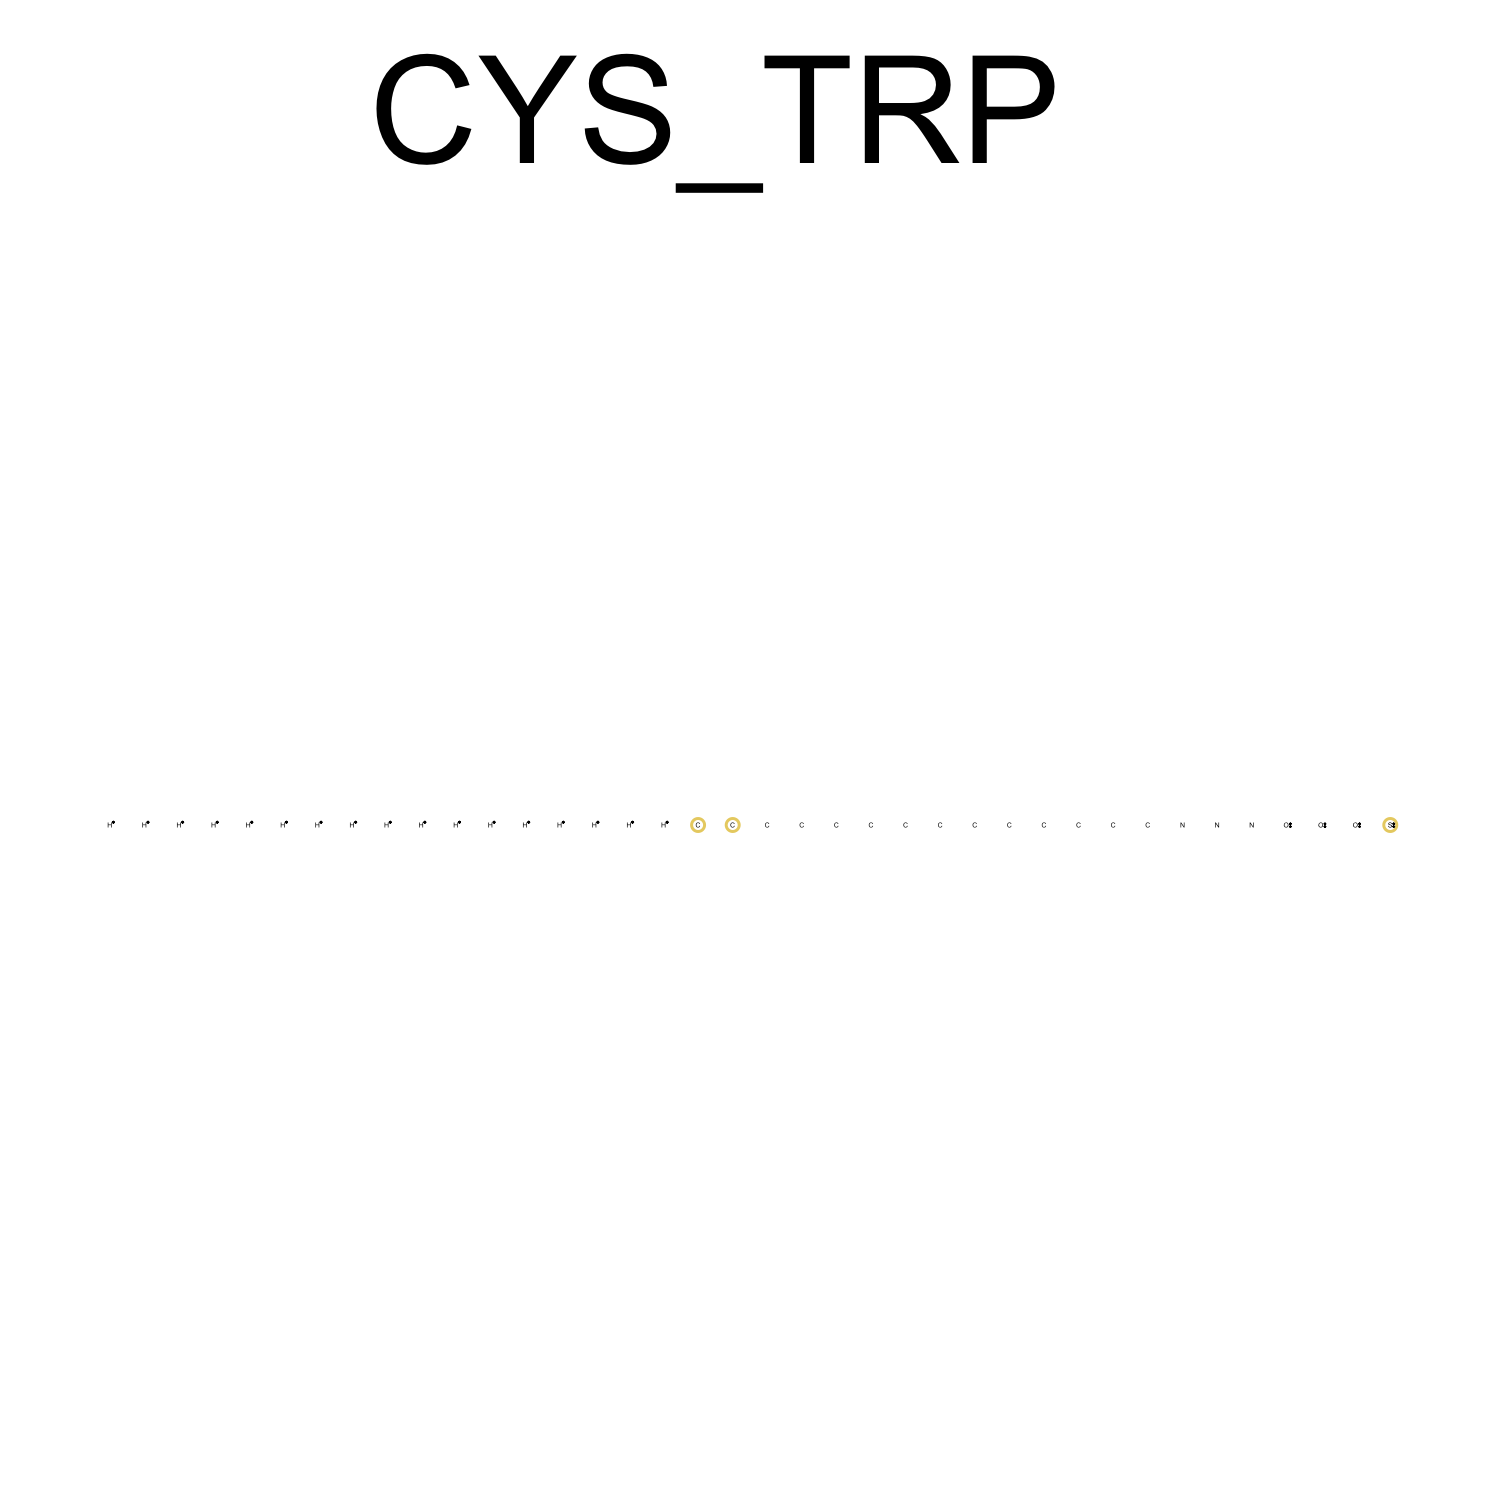

50.000	118.000
70.000	117.000
63.000	110.100
63.000	114.000
80.000	120.400
50.000	121.900
80.000	109.700
70.000	125.000
50.000	118.400
63.000	120.000
70.000	120.000
63.000	106.400
70.000	108.700
63.000	115.600
70.000	128.600
63.000	116.200
70.000	111.600
50.000	113.000
50.000	123.200
43.000	96.000
80.000	111.200
70.000	132.800
62.000	98.900
63.000	111.100
80.000	126.000
63.000	113.100
50.000	120.000
50.000	114.700
70.000	104.400
40.000	109.500
55.000	108.500
80.000	122.900
50.000	118.040
63.000	134.900
35.000	120.000
35.000	109.500
63.000	108.800
63.000	122.700
50.000	109.500
70.000	116.600
50.000	123.100


In [63]:
#def depictMatch(mol, match=None, supH = True, idx_atoms=list(), width=500, height=200, fn=None,
#               color1=oechem.OELightBlue, color2=oechem.OELightSalmon, include_bonds=True):

# file name will have the form:
# [prop]_[cluster]_[mol]_[atom_indice_count]

alpha_list = [255, 51, 153]
final_colors = list()

for a in alpha_list:
    for c in oechem.OEGetContrastColors():
        temp_c = c.CreateCopy()
        temp_c.SetA(a)
        final_colors.append(temp_c)


for c_idx, (p_lab, cluster) in enumerate(dis_cluster_types['angle']):
    print(p_lab)
    if c_idx > 1:
        continue
    color = final_colors[c_idx]
    for mol_idx, atom_indice_list in enumerate(cluster):
        if mol_idx != 44:
            continue
        if len(atom_indice_list) == 0:
            continue
        print('-'*80)
        m = oechem.OEMol(dis_mols[mol_idx])
        #oechem.OEPerceiveBondOrders(m)
        #oechem.OEClearAromaticFlags(m)
        #oechem.OEAssignAromaticFlags(m, oechem.OEAroModel_MDL)
        #oechem.OEAssignHybridization(m)
        aros = [atom for atom in m.GetAtoms() if atom.IsAromatic()]
        print(mol_idx, oechem.OECount(m, oechem.OEIsAromaticAtom())) 
            
        
        #m.SetTitle(p_lab)
        for a_idx, a in enumerate(atom_indice_list):
            if a_idx > 1:
                continue
            img = depictMatch(m, supH=True, idx_atoms=a, color1=color, width=1500, height=1500, fn="/Users/bannanc/Desktop/'cys_trp.pdf")
            display(Image(oedepict.OEWriteImageToString("png",img)))
        

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10654fde0> >

# Try making SMIRKS for all dipeptides

In [21]:
temp_clusters = [(l,c[:2]) for (l,c) in clusters]

len(temp_clusters), len(remove_empties(temp_clusters))

(33, 22)

# try various number of peptides

In [25]:
def remove_empties(clusters):
    new_cs = list()
    for label, c in clusters:
        temp_c = [i for i in c if len(i) > 0]
        if len(temp_c) > 0:
            new_cs.append((label,c))
    return new_cs

all_dis_test = dict()
subsets = [2, 5, 10, 30, 50, 100, 150, 190]

for n in subsets:
    all_dis_test[n] = dict()
    for label, clusters in dis_cluster_types.items():
        print(label)
        temp_mols = dis_mols[:n]
        temp_clusters = remove_empties([(l,c[:2]) for (l,c) in clusters])
        print(len(temp_mols), len(temp_clusters[0][1]))
        try: 
            all_dis_test[n][label] = SMIRKSifier(dis_mols, clusters, max_layers=10, strict_smirks=False)
        except Exception as e: 
            all_dis_test[n][label] = e

charge
2 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H0X3x0!r+0A](-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
2 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3

lj
2 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r;+

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
2 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A])

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
5 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
5 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3

lj
5 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r;+

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
5 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A])

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
10 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
10 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1X

lj
10 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r;

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
10 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#1H0X1,#6H0X3,#6H1X3,#6H1X4,#6H2X4,#6H3X4,#7H1X3,#7H2X3,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
30 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
30 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1X

lj
30 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r;

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
30 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A]

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
50 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
50 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1X

lj
50 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r;

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
50 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#1H0X1,#6H0X3,#6H1X3,#6H1X4,#6H2X4,#6H3X4,#7H1X3,#7H2X3,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
100 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
100 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1

lj
100 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
100 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
150 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
150 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1

lj
150 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
150 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge
190 2

 Label                | SMIRKS 
 zz_-0.798            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#16H1X2x0!r+0A]-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H1X3x0!r+0A](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A](-;!@[#6H1X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#7H3X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#1H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A])-;!@[#8H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_-0.822            | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A](-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
bond
190 2

 Label                | SMIRKS 
 zz_477.000	1.343     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#7H0X2x0!r+0A])-;!@[#7H1X3x0!r+0A:2](-;!@[#1H0X1x0!r+0A])-;!@[#6H1X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_450.000	1.364     | [#6H0X3x0!r+0A:1](-;!@[#6H1X3x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#8H1X2x0!r+0A:2]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.404     | [#6H1X3x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X3x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#6H0X3x0!r+0A])-;!@[#6H0X3x0!r+0A] 
--------------------------------------------------------------------------------
 zz_469.000	1.409     | [#6H0X3x0!r+0A:1](-;!@[#6H1

lj
190 2

 Label                | SMIRKS 
 zz_0.086	1.908       | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#6H1X4,#6H2X4,#7H1X3;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X3,#7H0X2,#7H0X3,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H0X3,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.100       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H2,#7H3;!r;+0;X4;x0;A] 
--------------------------------------------------------------------------------
 zz_0.210	1.721       | [#8H1X2x0!r+0A:1](-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A](-;!@[#1H0X1,#6H1X3;!r;+0;x0;A])-;!@[#6X3,#6X4;!r;+0;H1;x0;A] 
--------------------------------------------------------------------------------
 zz_0.016	1.487       | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2,#6H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1,#6H3X4;!r

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
angle
190 2

 Label                | SMIRKS 
 zz_35.000	109.500    | [#1H0X1x0!r+0A:1]-;!@[#6H2,#6H3,#7H2,#7H3;!r;+0;X4;x0;A:2](-;!@[#16H0X2,#16H1X2,#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H1X2;!r;+0;x0;A])(-;!@[#16H0X2,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A]-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X3,#7H1X3,#7H2X4,#7H3X4,#8H0X1;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_80.000	122.900    | [#8H0X1x0!r+0A:1]-;!@[#6H0X3x0!r+0A:2](-;!@[#6H1,#6H2;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H1,#6H2,#7H2,#7H3;!r;+0;X4;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4;!r;+0;x0;A])(-;!@[#1H0X1,#7H1X3,#7H3X4;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      


In [26]:
for num, smirs_dis in all_dis_test.items():
    print('='*80, '\n', num, '\n', '='*80)
    for label, output in smirs_dis.items():
        if isinstance(output, Exception):
            print(label, 'error')
            continue
        if not output.checks:
            print(label, 'failed to make smirks')
            continue
        print(label, 'passes')

 50 
charge failed to make smirks
bond passes
lj passes
improper_torsion failed to make smirks
proper_torsion failed to make smirks
angle failed to make smirks
 100 
charge failed to make smirks
bond passes
lj passes
improper_torsion failed to make smirks
proper_torsion failed to make smirks
angle failed to make smirks
 5 
charge failed to make smirks
bond passes
lj passes
improper_torsion failed to make smirks
proper_torsion failed to make smirks
angle failed to make smirks
 150 
charge failed to make smirks
bond passes
lj passes
improper_torsion failed to make smirks
proper_torsion failed to make smirks
angle failed to make smirks
 10 
charge failed to make smirks
bond passes
lj passes
improper_torsion failed to make smirks
proper_torsion failed to make smirks
angle failed to make smirks
 2 
charge failed to make smirks
bond passes
lj passes
improper_torsion failed to make smirks
proper_torsion failed to make smirks
angle failed to make smirks
 30 
charge failed to make smirks
bond p

# Try to make SMIRKS for tetrapeptides

In [36]:
for label, clusters in cluster_types.items():
    print(label, len(mols), len(clusters), len(clusters[0][1]))

proper_torsion 190 30 190
improper_torsion 190 3 190
lj 190 14 190
bond 190 33 190
angle 190 42 190
charge 190 181 190


In [ ]:
smirs = dict()
for label, clusters in cluster_types.items():
    print(label)
    try: 
        smirs[label] = SMIRKSifier(mols, clusters, max_layers=10, strict_smirks=False)
    except Exception as e: 
        smirs[label] = e

proper_torsion

 Label                | SMIRKS 
 zz_5.375	180.000	2.000 | [#1H0X1,#6H2X4,#7H0X2;!r;+0;x0;A:1]-;!@[#6H0,#6H1;!r;+0;X3;x0;A:2](-;!@[#6H2X4,#7H0X2,#7H1X3;!r;+0;x0;A]-;!@[#6X3,#6X4;!r;+0;H1;x0;A]-;!@[#1H0X1x0!r+0A])-;!@[#6H0,#6H1;!r;+0;X3;x0;A:3](-;!@[#1H0X1,#6H2X4,#7H1X3;!r;+0;x0;A])-;!@[#1H0X1,#7H0X2,#7H1X3;!r;+0;x0;A:4] 
--------------------------------------------------------------------------------
 zz_0.250	0.000	1.000	0.000	0.000	3.000 | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H3;!r;+0;X4;x0;A:2](-;!@[#1X1,#6X3;!r;+0;H0;x0;A])(-;!@[#1H0X1,#7H1X3;!r;+0;x0;A])-;!@[#6H1,#6H2;!r;+0;X4;x0;A:3](-;!@[#1H0X1,#6H1X4,#6H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#8H1X2x0!r+0A:4]-;!@[#1H0X1x0!r+0A] 
--------------------------------------------------------------------------------
 zz_0.800	0.000	1.000	0.000	0.000	2.000	0.080	180.000	3.000 | [#1H0X1x0!r+0A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A:2](-;!@[#1H0X1,#7H0X3,#7H1X3;!r;+0;x0;A])(-;!@[#6H1X4,#6H2X4,#6H3X4,#7H1X3;!r;+0;x0;A](-;!@[#1H0X1,#6H0X3,

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
improper_torsion

 Label                | SMIRKS 
 zz_10.500	180.000	2.000 | [#6H1X4,#6H2X4,#7H2X3;!r;+0;x0;A:1](-;!@[#1H0X1,#7H0X3,#7H1X3,#7H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#7H0X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A:3])-;!@[#7H1X3,#8H0X1;!r;+0;x0;A:4] 
--------------------------------------------------------------------------------
 zz_1.000	180.000	2.000 | [#6H0,#6H1;!r;+0;X3;x0;A:1](-;!@[#1H0X1,#6H1X3,#7H1X3,#7H2X3,#8H0X1;!r;+0;x0;A])(-;!@[#6H0X3,#6H1X4,#6H2X4,#7H0X2,#7H2X3;!r;+0;x0;A]-;!@[#1H0X1,#6H0X3,#6H2X4;!r;+0;x0;A])-;!@[#7H0,#7H1,#7H2;!r;+0;X3;x0;A:2](-;!@[#1H0X1,#6H1X3,#6H2X4;!r;+0;x0;A:3])-;!@[#1H0X1,#6H1X4;!r;+0;x0;A:4] 
--------------------------------------------------------------------------------
 zz_

angle

 Label                | SMIRKS 
 zz_80.000	120.400    | [#6H1,#6H2;!r;+0;X4;x0;A:1](-;!@[#1H0X1,#7H0X3,#7H1X3,#7H3X4;!r;+0;x0;A])(-;!@[#1H0X1x0!r+0A])(-;!@[#6H1X4,#6H2X4,#6H3X4,#7H1X3;!r;+0;x0;A](-;!@[#1H0X1,#6H0X3,#6H1X4,#6H2X4,#6H3X4,#8H1X2;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A])-;!@[#6H0X3x0!r+0A:2](-;!@[#7H0,#7H1,#7H2;!r;+0;X3;x0;A](-;!@[#1H0X1,#6H1X4,#6H2X4;!r;+0;x0;A])-;!@[#1H0X1,#6H2X4;!r;+0;x0;A])-;!@[#8H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_50.000	120.000    | [#6H0X3,#6H1X3,#7H0X2,#7H1X3;!r;+0;x0;A:1](-;!@[#1H0X1,#6H0X3,#6H2X4,#7H2X3,#8H0X1,#8H1X2;!r;+0;x0;A])-;!@[#6H1,#7H1,#7H2;!r;+0;X3;x0;A:2](-;!@[#1H0X1,#6H0X3,#6H1X3,#6H1X4,#6H2X4,#7H0X2,#7H1X3;!r;+0;x0;A])-;!@[#1H0X1x0!r+0A:3] 
--------------------------------------------------------------------------------
 zz_50.000	123.200    | [#6H2X4x0!r+0A:1](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])(-;!@[#6H2X4x0!r+0A](-;!@[#1H0X1x0!r+0A])(-;!@[#1H0X1x0!r+0A])-;!@[#6H2X

WARNING! 
                      SMIRKSifier was not able to create SMIRKS for the provided
                      clusters with 10 layers. Try increasing the number of layers
                      or changing your clusters
                      
charge


# Try making molecules from `fasta` files

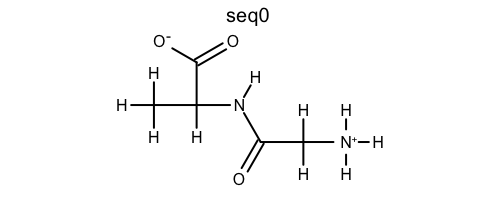

In [368]:
fasta = './mol_files/ALA_GLY.fasta'
base = fasta.split('.')[0]
mol_id = base.split('/')[-1]

oemol = oechem.OEMol()
ifs = oechem.oemolistream(fasta)

oechem.OEReadFASTAFile(ifs,oemol)
oechem.OEAddExplicitHydrogens(oemol)
temp_mol = oechem.OEMol(oemol)

oechem.OEPerceiveResidues(oemol)
oechem.OEPDBOrderAtoms(oemol)

ofs = oechem.oemolostream()
ofs.SetFormat(oechem.OEFormat_PDB)
ofs.openstring()
oechem.OEWriteMolecule(ofs,oemol)

ifs = oechem.oemolistream()
ifs.openstring(ofs.GetString())
ifs.SetFormat(oechem.OEFormat_PDB)
m = oechem.OEMol()
oechem.OEReadPDBFile(ifs,m)

top = oeo_utils.oemol_to_openmmTop(m)[0]
ff_file = 'amber99sbildn.xml'
ff_file = 'amber99sb.xml'
ff = app.ForceField(ff_file)
protein_sys = ff.createSystem(top)
parm = parmed.openmm.load_topology(top, protein_sys)

oechem.OEAssignFormalCharges(m)
img = depictMatch(m, supH=False)
display(Image(oedepict.OEWriteImageToString("png",img)))

# EXAMPLE using fasta works for one dipeptide

Now I need to automate looping over single amino acid codes to make a full set of molecules

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x110da11e0> >


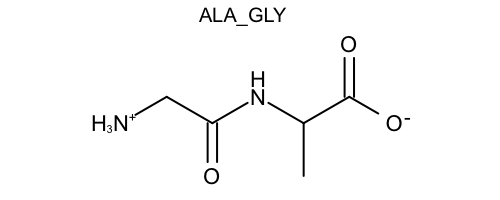

In [418]:
store = parameter_system()
parm, oemol = store.add_system_from_fasta('./mol_files/ALA_GLY.fasta')
ms, ctypes = store.convert_for_smirksifying()

In [390]:
import random
smirs = dict()

for label, clusters in ctypes.items():
    random.shuffle(clusters)
    print(label)
    try: 
        smirs[label] = SMIRKSifier(ms, clusters, max_layers=10, strict_smirks=False)
    except Exception as e: 
        smirs[label] = e

proper_torsion

 Label                | SMIRKS 
 zz_2.500	180.000	2.000 | [#6H2X4,#8H0X1;!r;+0;x0;A:1]-,=;!@[#6H0X3x0!r+0A:2]-;!@[#7H1X3x0!r+0A:3]-;!@[#1H0X1,#6H1X4;!r;+0;x0;A:4] 
--------------------------------------------------------------------------------
 zz_0.156	0.000	3.000 | [#1H0X1,#6H0X3,#7H1X3;!r;+0;x0;A:1]-;!@[#6H1,#6H2;!r;+0;X4;x0;A:2]-;!@[#6+0,#7+1;!r;H3;X4;x0;A:3]-;!@[#1H0X1x0!r+0A:4] 
--------------------------------------------------------------------------------
 zz_0.400	0.000	3.000	2.000	0.000	2.000	2.000	0.000	1.000 | [#6H0X3x0!r+0A:1]-;!@[#7H1X3x0!r+0A:2]-;!@[#6H1X4x0!r+0A:3]-;!@[#6H3X4x0!r+0A:4] 
--------------------------------------------------------------------------------
 zz_0.420	0.000	3.000	0.270	0.000	2.000 | [#6H0X3x0!r+0A:1]-;!@[#7H1X3x0!r+0A:2]-;!@[#6H1X4x0!r+0A:3]-;!@[#6H0X3x0!r+0A:4] 
--------------------------------------------------------------------------------
 zz_2.500	180.000	2.000	2.000	0.000	1.000 | [#8H0X1x0!r+0A:1]=;!@[#6H0X3x0!r+0A:2]-;!@

In [391]:
for label, output in smirs.items():
    if not output.checks:
        print(label, 'FAILED to make smirks')
        continue
    print(label, 'PASSED')

proper_torsion PASSED
bond PASSED
improper_torsion PASSED
charge PASSED
lj PASSED
angle PASSED


0.156	0.000	3.000
--------------------------------------------------------------------------------
0 0


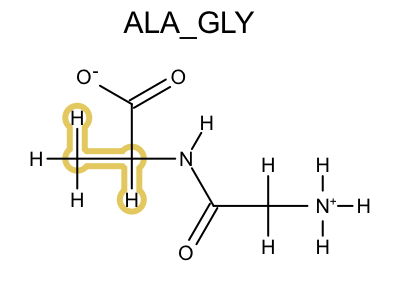

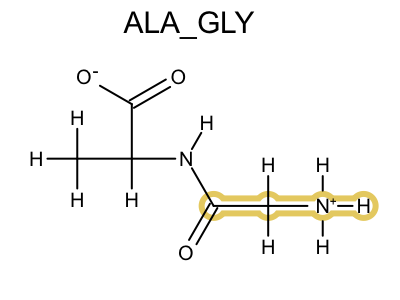

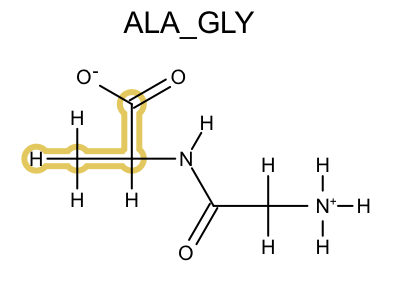

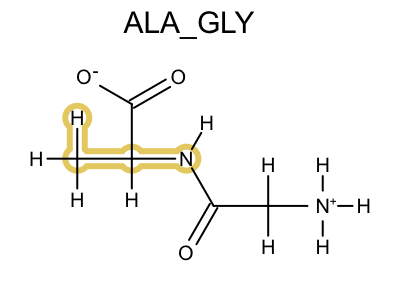

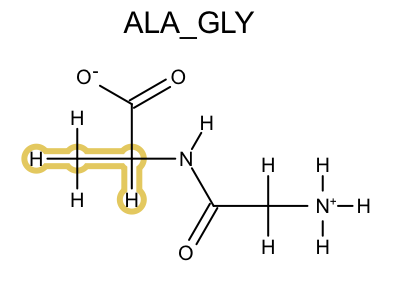

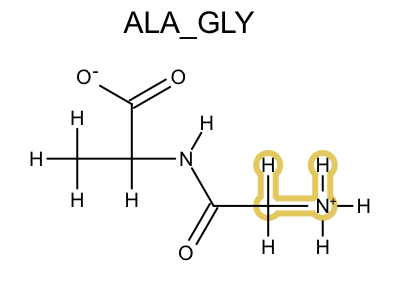

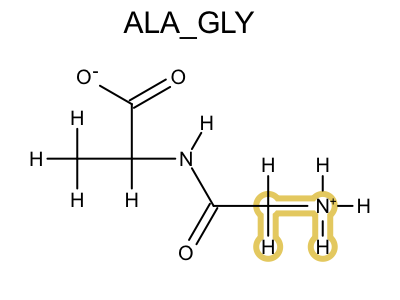

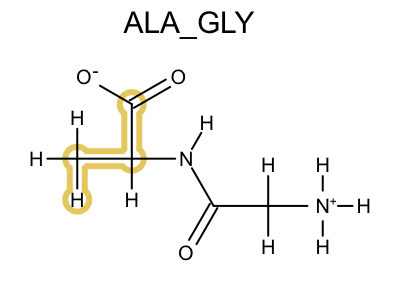

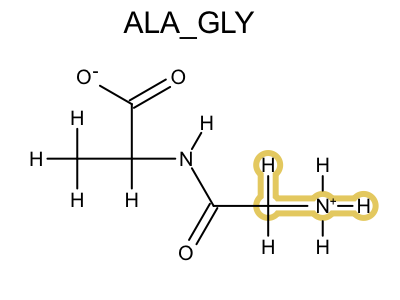

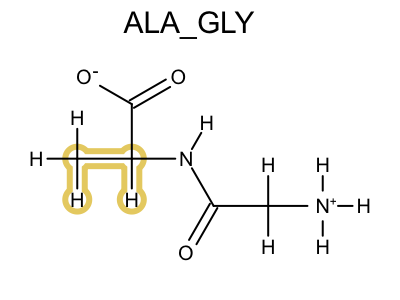

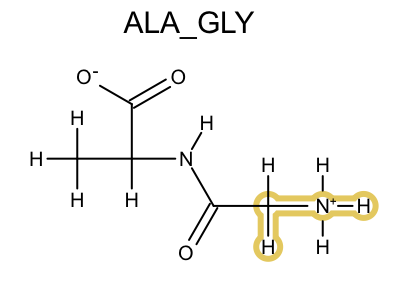

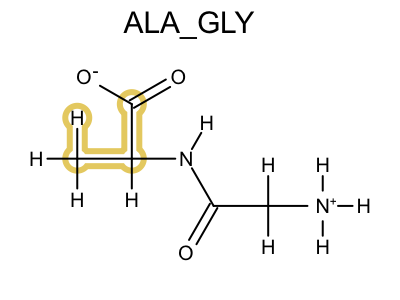

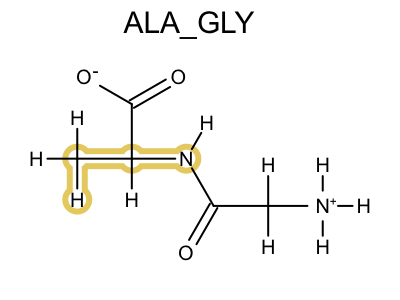

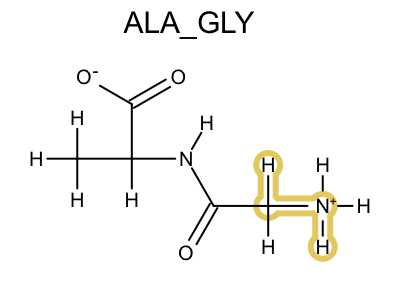

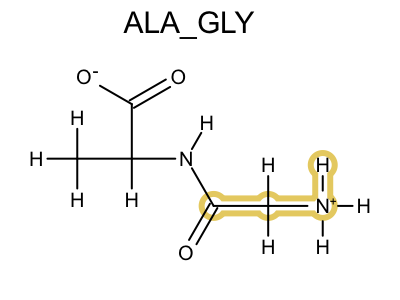

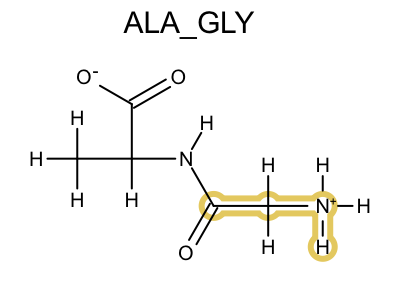

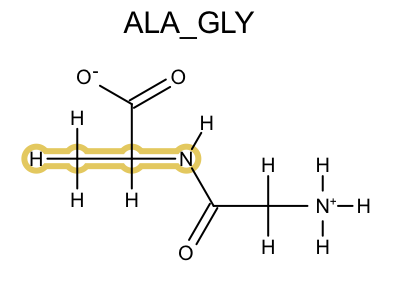

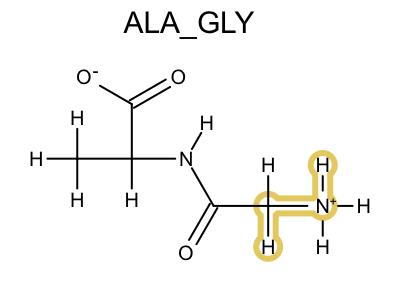

2.500	180.000	2.000
--------------------------------------------------------------------------------
0 0


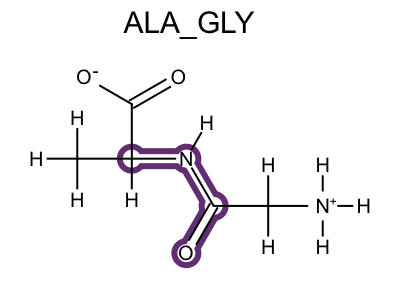

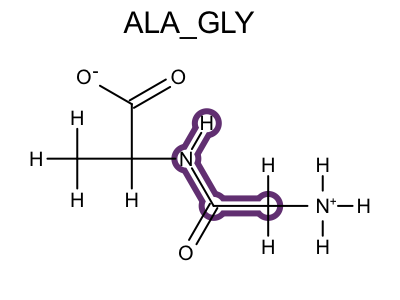

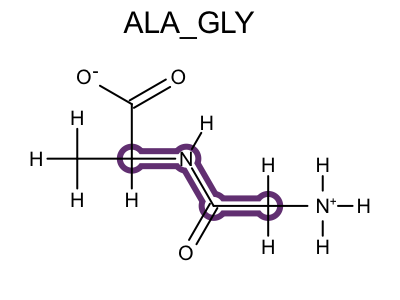

0.400	0.000	3.000	2.000	0.000	2.000	2.000	0.000	1.000
--------------------------------------------------------------------------------
0 0


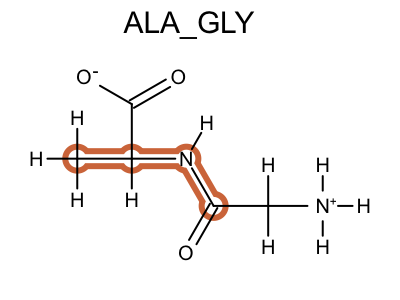

2.500	180.000	2.000	2.000	0.000	1.000
--------------------------------------------------------------------------------
0 0


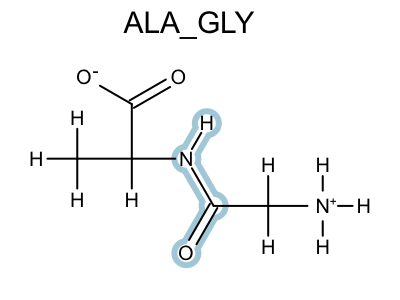

0.420	0.000	3.000	0.270	0.000	2.000
--------------------------------------------------------------------------------
0 0


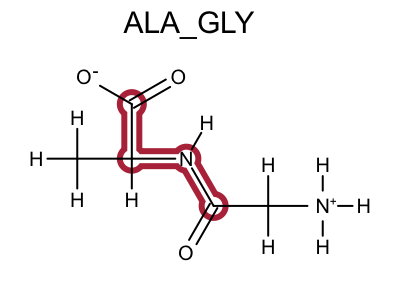

In [389]:
for c_idx, (p_lab, cluster) in enumerate(ctypes['proper_torsion']):
    print(p_lab)
    color = final_colors[c_idx]
    for mol_idx, atom_indice_list in enumerate(cluster):
        if len(atom_indice_list) == 0:
            continue
        print('-'*80)
        m = oechem.OEMol(ms[mol_idx])
        aros = [atom for atom in m.GetAtoms() if atom.IsAromatic()]
        print(mol_idx, oechem.OECount(m, oechem.OEIsAromaticAtom())) 
            
        
        #m.SetTitle(p_lab)
        for a_idx, a in enumerate(atom_indice_list):
            img = depictMatch(m, supH=False, idx_atoms=a, color1=color, width=400, height=300)
            display(Image(oedepict.OEWriteImageToString("png",img)))

proper_torsion failed to make smirks
bond passes
improper_torsion passes
charge passes
lj passes
angle passes


# Make fasta files

In [392]:
singles = ['G', 'A', 'V', 'L', 'I', 'M', 'F', 'W', 'P', 'S', 'T', 'C', 'Y', 'N', 'Q', 'D', 'E', 'K', 'R', 'H']

In [413]:
def make_di_fasta_file(pair, directory):
    p1, p2 = pair
    fasta_str = """
>%s%s
%s%s
""" % (p1, p2, p1, p2)
    fn = '%s/%s_%s.fasta' % (directory, p1,p2)
    
    f = open(fn,'w')
    f.write(fasta_str)
    f.close()

In [415]:
directory = os.path.abspath("./mol_files/")
for p in itertools.combinations_with_replacement(singles, 2):
    make_di_fasta_file(p,directory)

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10fb197e0> >


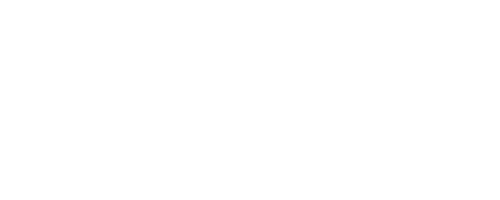

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x110e52ea0> >


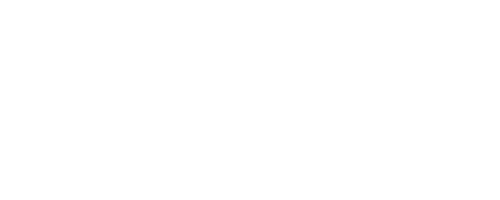

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10c9e3db0> >


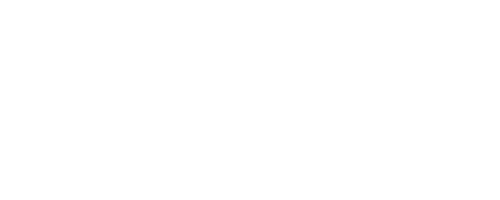

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x110e52c90> >


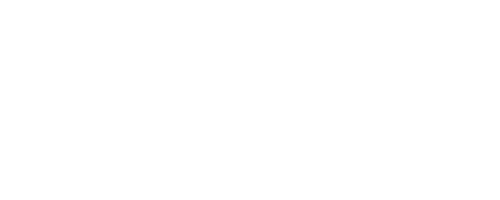

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10c9e3db0> >


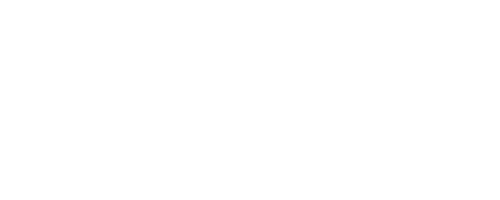

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10c9e3de0> >


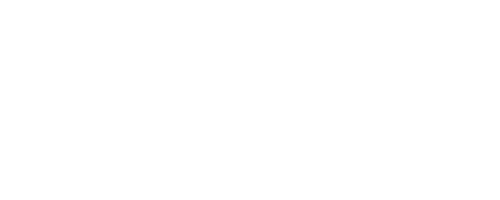

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10c8518d0> >


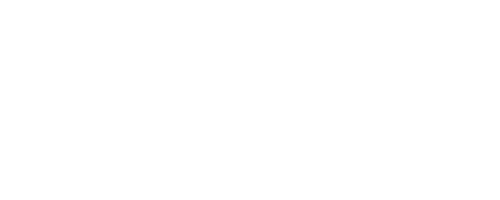

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x104a970f0> >


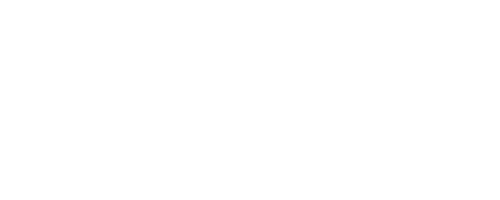

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x104a972a0> >


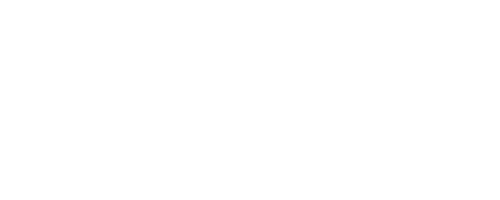

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x104a52de0> >


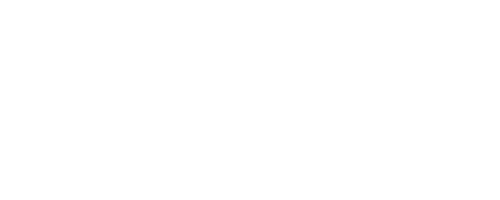

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10c8518d0> >


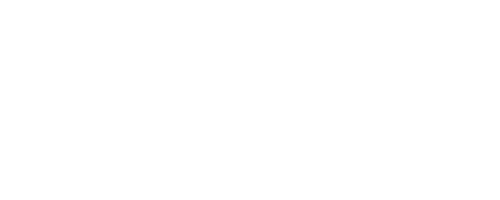

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10f717270> >


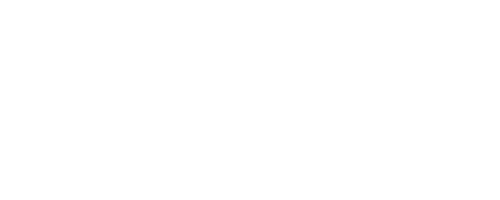

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x111fbe900> >


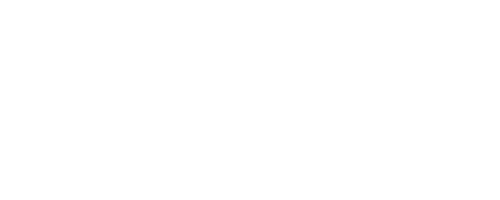

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x104a972a0> >


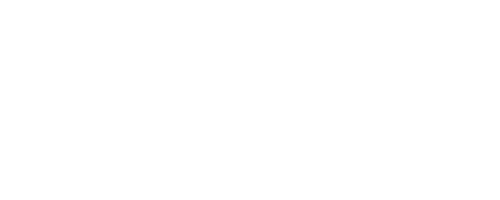

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x104a52de0> >


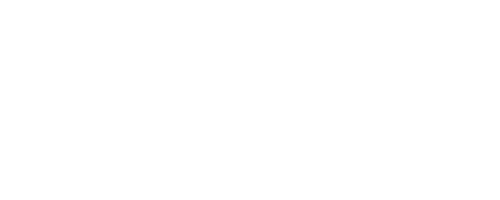

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x10c9e3db0> >


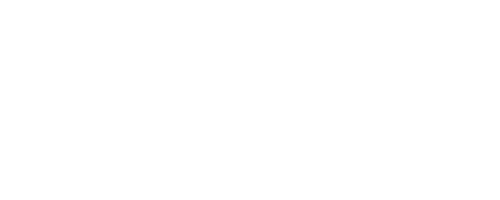

KeyboardInterrupt: 

In [417]:
cwd = os.getcwd()
fastas = glob.glob('%s/mol_files/*.fasta' % cwd)

store_data = parameter_system()

for fasta in fastas:
    parm, oemol = store_data.add_system_from_fasta(fasta)

In [58]:
tet_mols, tet_cluster_types = tetras_store_data.convert_for_smirksifying()

for label, clusters in tet_cluster_types.items():
    print(label, len(tet_mols), len(clusters), len(clusters[0][1]))

proper_torsion 190 30 190
bond 190 33 190
improper_torsion 190 3 190
charge 190 181 190
lj 190 14 190
angle 190 42 190


In [59]:
mols, cluster_types = tetras_store_data.convert_for_smirksifying()